# Correlation analysis between the Bitcoin currency and Twitter

In [2]:
import pandas as pd
import io
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta

## Set the currency and the data files

In [12]:
# Define the currency

CURRENCY = "bitcoin"
CURRENCY_SYMBOL = "BTC"

#tweets_clean_file = f'{TWITTER_FOLDER}/{CURRENCY}_tweets_clean.csv'

## Load the datasets

We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The extraction process is detailed in these notebooks so please refer to them for any information needed. Here we simply gather all the extracted data to generate two datasets :

- The twitter dataset : contains historical tweets related to the targeted crypto currency with a sentiment score.
- The crypo dataset : contains historical data of the crypto currency we target with the change in USD.

### Twitter dataset

The data is split into multiple files. Here it is gathered into a single dataframe.

In [41]:
#tweets = pd.read_csv(tweets_clean_file)

tweets = pd.read_csv('D:/Parth/Documents/MS DS/Projects/DS5220 Supervised Machine Learning/Crypto-Sentiment-Analysis/Data/tweets/bitcoin_tweets_cleaned_sent.csv')
#tweets = tweets.sort_values(by=['ID'])

# Drop duplicate tweets
#print('tweet shape before droping duplicates', tweets.shape)
#duplicates_removed = tweets.shape[0]
#tweets = tweets.drop_duplicates(subset=['date'])
#duplicates_removed -= tweets.shape[0]
#print('tweet shape after droping duplicates', tweets.shape)
#print('duplicates removed', duplicates_removed)

# Display dataframes head
tweets.head(2)

c:\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,text,is_retweet,subjectivity,polarity,sentiment,vader_compound,vader_pos,vader_neg,vader_neu,afinn_score
0,2021-02-05 10:52:04,debunking bitcoin myths by patrick lowry cryp...,False,0.0,0.0,neutral,0.0000,0.000,0.0,1.000,0.0
1,2021-02-05 10:52:04,weekend read keen to learn about crypto asset...,False,0.0,0.0,neutral,0.4939,0.244,0.0,0.756,3.0


### Crypto dataset

In [42]:
crypto_usd = pd.read_csv('D:/Parth/Documents/MS DS/Projects/DS5220 Supervised Machine Learning/Crypto-Sentiment-Analysis/Data/prices/btcusd.csv')
crypto_usd.head(2)

,time,open,close,high,low,volume
0,1364774820000,93.25,93.3,93.3,93.25,93.3
1,1364774880000,100.00,100.0,100.0,100.00,93.3


## Group by and sum by timeframe

In [43]:
tweets['date'] = pd.to_datetime(tweets['date'])
tweets.index = tweets['date']



crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='ms')
crypto_usd.index = crypto_usd['time']

crypto_usd=crypto_usd[crypto_usd['time'] >= tweets['date'].min()]
tweets=tweets[tweets['date'] <= crypto_usd['time'].max()]


tweets_grouped = tweets.groupby(pd.Grouper(key='date', freq='1h'))['afinn_score'].sum()
crypto_usd_grouped = crypto_usd.groupby(pd.Grouper(key='time', freq='1h'))['close'].mean()

### Plotting the scores
We calculate the mean of each tweets grouped by hour and then we plot it.

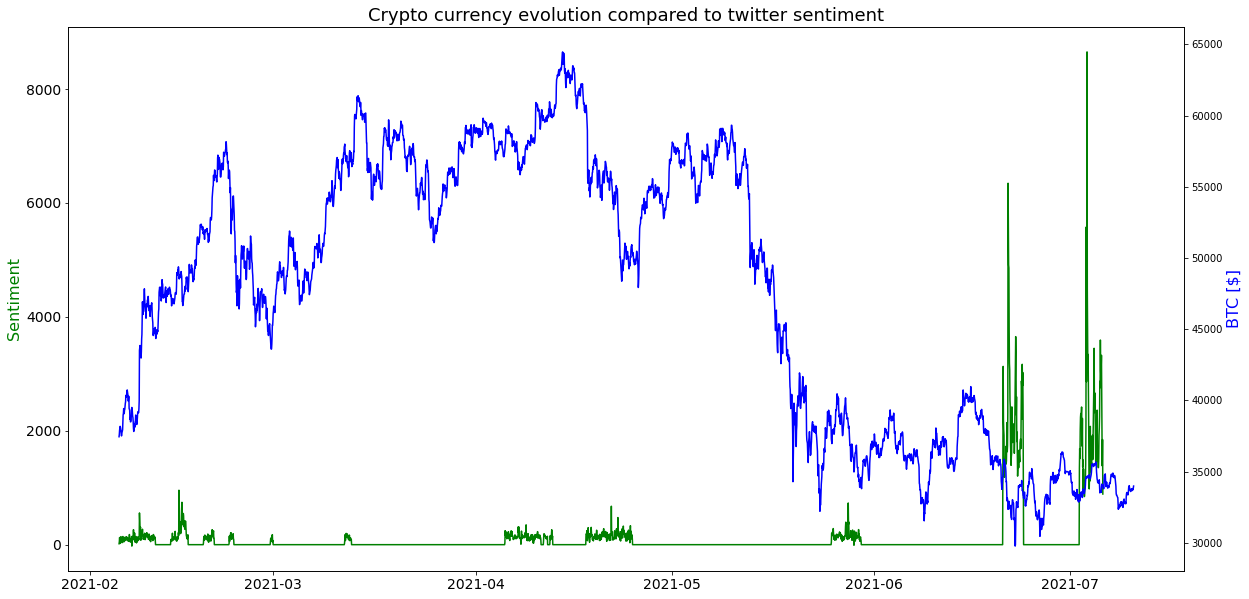

In [44]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

## Correlation analysis
Here we make the correlation analysis between BTC/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

In [45]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

### Crop the time series to match the time frames

In [46]:
beggining = max(tweets_grouped.index.min(), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max(), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

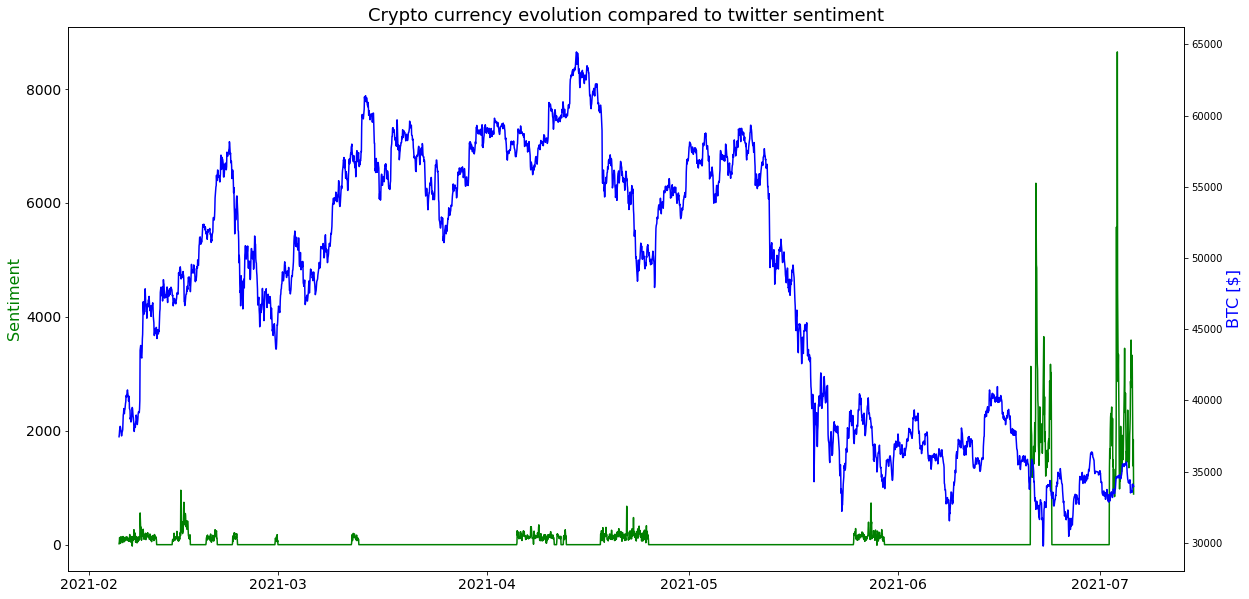

In [47]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

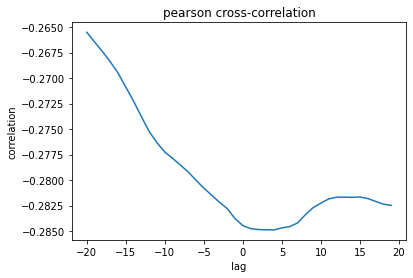

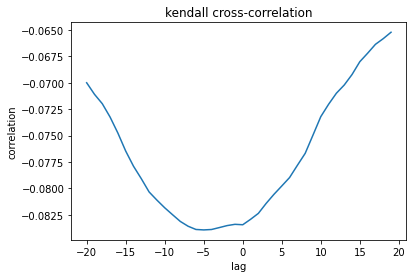

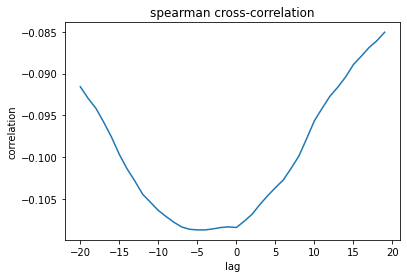

In [48]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize 
First we need to normalize the data.

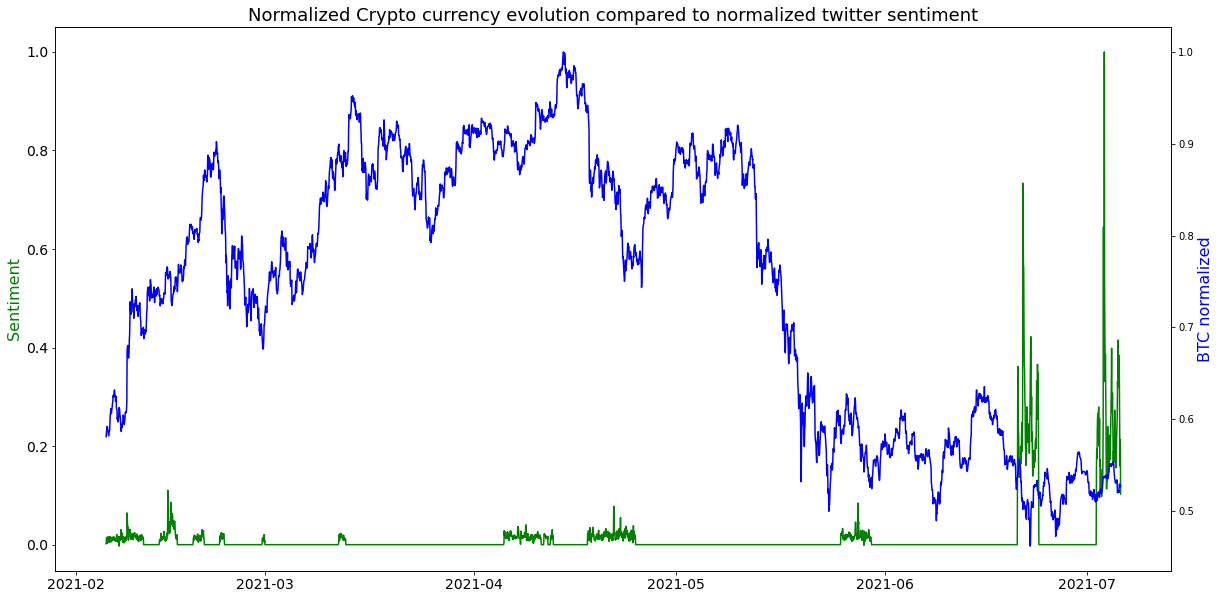

In [49]:
# Normalize time series data
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} normalized", color='b', fontsize=16)
plt.show()

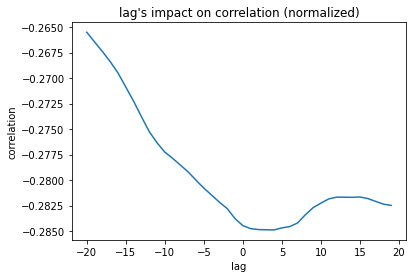

In [50]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Calculate derivative

The derivative is calculated to define an increase or a decrease of the crypto currency.

The score is as well derivated to observe the increase or decrease of the score.

Computing the derivative could help to find a correlation.

In [51]:
# Derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

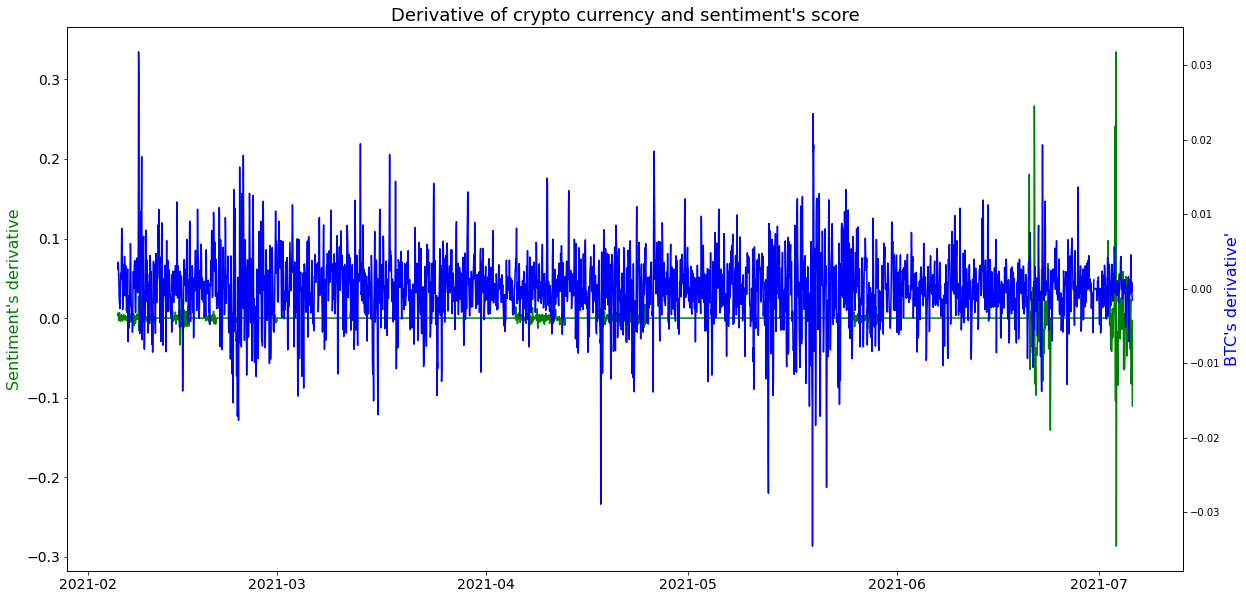

In [52]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL}'s derivative'", color='b', fontsize=16)
plt.show()

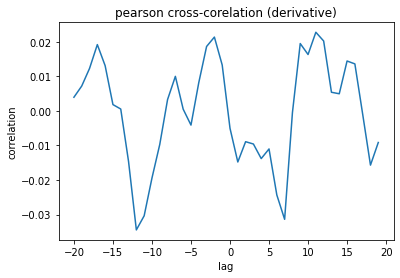

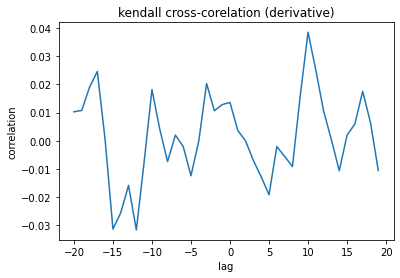

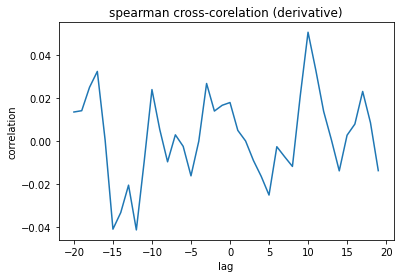

In [53]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()